In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [2]:
df = pd.read_csv('first30.csv')
df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461
1,0,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040
2,0,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,0.701,99.259
3,0,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,0.891,0.714,4.0,-6.055,0.0,0.1400,0.20200,0.000234,0.0521,0.818,100.972
4,0,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,0.654,94.759


In [3]:
dic = dict()
# construct dictionary
for i, row in df.iterrows():
    if row['pid'] in dic:
        dic[row['pid']].append(row['track_uri'])
    else:
        dic[row['pid']] = [row['track_uri']]

In [4]:
df.columns

Index(['pid', 'pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name',
       'album_uri', 'duration_ms', 'album_name', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [5]:
useful_col = ['pid', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo' ]

In [6]:
# keep song features
df = df[useful_col]
df.head()

,pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461
1,0,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040
2,0,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,0.701,99.259
3,0,0.891,0.714,4.0,-6.055,0.0,0.1400,0.20200,0.000234,0.0521,0.818,100.972
4,0,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,0.654,94.759


In [7]:
df1 = df.groupby('pid').agg({'danceability':['mean', 'max', 'min'], 
                             'energy':['mean', 'max', 'min'],
                             'key':['mean', 'max', 'min'], 
                             'loudness':['mean', 'max', 'min'],
                            'speechiness':['mean', 'max', 'min'],
                             'instrumentalness':['mean', 'max', 'min'],
                             'liveness':['mean', 'max', 'min'], 
                             'valence':['mean', 'max', 'min'], 
                             'tempo':['mean', 'max', 'min']})

In [8]:
# featurize a playlist by using features of songs that are in it
df1.head()

danceability                   energy                      key             \
            mean    max     min      mean    max     min      mean   max  min   
pid                                                                             
0       0.664077  0.938  0.3500  0.781077  0.976  0.4540  5.038462  11.0  0.0   
1       0.496382  0.829  0.0849  0.690821  0.975  0.2050  4.461538  11.0  0.0   
2       0.671844  0.853  0.3890  0.693438  0.922  0.2460  5.000000  11.0  0.0   
3       0.513619  0.890  0.1500  0.620901  0.986  0.0134  5.103175  11.0  0.0   
4       0.576765  0.863  0.2870  0.650535  0.911  0.0861  3.352941   9.0  0.0   

     loudness  ... instrumentalness  liveness                  valence         \
         mean  ...              min      mean    max     min      mean    max   
pid            ...                                                              
0   -4.891212  ...              0.0  0.187106  0.722  0.0268  0.642769  0.965   
1   -8.293949  ...              0.0  0.178649  0.657  0.0438  0.476333  0.886   
2   -4.874484  ...              0.0  0.169031  0.631  0.0504  0.564641  0.961   
3   -9.618468  ...              0.0  0.188333  0.869  0.0353  0.450933  0.970   
4   -7.634471  ...              0.0  0.166524  0.709  0.0298  0.490765  0.964   

                  tempo                   
        min        mean      max     min  
pid                                       
0    0.1950  121.157538  210.857  65.025  
1    0.1330  122.671282  185.397  71.105  
2    0.1660  114.602109  189.577  48.973  
3    0.0385  125.032460  190.985  61.891  
4    0.1290  127.759882  174.302  80.316  

[5 rows x 27 columns]

In [9]:
df1.columns

MultiIndex([(    'danceability', 'mean'),
            (    'danceability',  'max'),
            (    'danceability',  'min'),
            (          'energy', 'mean'),
            (          'energy',  'max'),
            (          'energy',  'min'),
            (             'key', 'mean'),
            (             'key',  'max'),
            (             'key',  'min'),
            (        'loudness', 'mean'),
            (        'loudness',  'max'),
            (        'loudness',  'min'),
            (     'speechiness', 'mean'),
            (     'speechiness',  'max'),
            (     'speechiness',  'min'),
            ('instrumentalness', 'mean'),
            ('instrumentalness',  'max'),
            ('instrumentalness',  'min'),
            (        'liveness', 'mean'),
            (        'liveness',  'max'),
            (        'liveness',  'min'),
            (         'valence', 'mean'),
            (         'valence',  'max'),
            (         'valence',  

In [10]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
# create cosine similarity matrix
cos_sim = cosine_similarity(df1)
cos_sim

array([[1.        , 0.99644076, 0.99863063, ..., 0.99539903, 0.99092338,
        0.99420003],
       [0.99644076, 1.        , 0.9948406 , ..., 0.9985185 , 0.98810437,
        0.99740721],
       [0.99863063, 0.9948406 , 1.        , ..., 0.99128431, 0.9913833 ,
        0.99519823],
       ...,
       [0.99539903, 0.9985185 , 0.99128431, ..., 1.        , 0.98756583,
        0.99457985],
       [0.99092338, 0.98810437, 0.9913833 , ..., 0.98756583, 1.        ,
        0.99412962],
       [0.99420003, 0.99740721, 0.99519823, ..., 0.99457985, 0.99412962,
        1.        ]])

In [13]:
# create eucliden distance matrix
sc = StandardScaler()
df_sc = sc.fit_transform(df1)
euc_sim = euclidean_distances(df_sc)
euc_sim

array([[ 0.        ,  5.6904178 ,  3.26901041, ...,  6.93826954,
        16.33242719,  8.3453051 ],
       [ 5.6904178 ,  0.        ,  5.38021448, ...,  5.91792107,
        12.91418208,  5.18951705],
       [ 3.26901041,  5.38021448,  0.        , ...,  5.67722493,
        15.43484307,  7.01083985],
       ...,
       [ 6.93826954,  5.91792107,  5.67722493, ...,  0.        ,
        13.14202447,  6.36925911],
       [16.33242719, 12.91418208, 15.43484307, ..., 13.14202447,
         0.        , 10.62221918],
       [ 8.3453051 ,  5.18951705,  7.01083985, ...,  6.36925911,
        10.62221918,  0.        ]])

In [14]:
def recommend_playlist(base, dic, cos_sim, split_ratio, cos=True):
    res = []
    base_tracks = set(dic[base])
    num_base = len(base_tracks)
    ratio = int(split_ratio * num_base)
    
    
    if cos:
        # get the most similar playlists in terms of cosine similarity
        sim_list = np.flip(np.argsort(cos_sim[base]))[1:]
    else:
        # get the most similar playlists in terms of eucidean similarity
        sim_list = np.argsort(cos_sim[base])[1:]
        
    for p in sim_list:
        p_tracks = set(dic[p])
        diff = list(p_tracks.difference(dic[base][:ratio]))
        cur_diff = num_base - len(res) 

        if cur_diff > 0:
            num_candi = len(diff)

            if num_candi <= cur_diff: 
                res.extend(diff)
            else:
                res.extend(diff[:cur_diff])
                break     
        else:
            break    
    return res

In [15]:
# demo to recommend songs for playlist 0
recommend_playlist(0, dic, cos_sim, 0.8)

['spotify:track:66TRwr5uJwPt15mfFkzhbi',
 'spotify:track:5OMwQFBcte0aWFJFqrr5oj',
 'spotify:track:6TrNRd98WksT9Kkmx9uj6R',
 'spotify:track:0qOnSQQF0yzuPWsXrQ9paz',
 'spotify:track:2oENJa1T33GJ0w8dC167G4',
 'spotify:track:2hM1BhWGjxCNZvRLtmz7bC',
 'spotify:track:6Z0F3Mqj7tq1CBZo5qMlUg',
 'spotify:track:5i66xrvSh1MjjyDd6zcwgj',
 'spotify:track:25FTMokYEbEWHEdss5JLZS',
 'spotify:track:7IhsLJMqdxoo7YAZjaSMru',
 'spotify:track:7AqISujIaWcY3h5zrOqt5v',
 'spotify:track:2ENexcMEMsYk0rVJigVD3i',
 'spotify:track:7yMnml7zdYl5LlDFZPm5Hd',
 'spotify:track:5tRifT4qX6gfmpEK2pUv4h',
 'spotify:track:5U4wYRHrCRxRP6iQfM824C',
 'spotify:track:27L8sESb3KR79asDUBu8nW',
 'spotify:track:1IpYDWB31L1CxDQZztadSi',
 'spotify:track:6mghCOaaSvrke0z1EUVUIf',
 'spotify:track:4XHQyvbrBsQaaBUW1VvmsL',
 'spotify:track:3Gf3Jsm0k6IPUkogQfKi7S',
 'spotify:track:0CAfXk7DXMnon4gLudAp7J',
 'spotify:track:7HGTkn2aX7MNdKs7nV2xBt',
 'spotify:track:1mr3616BzLdhXfJmLmRsO8',
 'spotify:track:4bPQs0PHn4xbipzdPfn6du',
 'spotify:track:

In [16]:
def eval_playlist(test_tracks, recommended_tracks):
    # r-precision
    test = set(test_tracks)
    pred = set(recommended_tracks)
    res = list(test & pred)
    return len(res) / len(test)


def recommend_eval(dic_eval, dic, split_ratio, cos_sim, cos=True):  
    res = []
    for base in dic_eval.keys():
        ratio = int(split_ratio*len(dic_eval[base]))
        recommended_tracks = recommend_playlist(base, dic, cos_sim, split_ratio, cos)
        r_precision = eval_playlist(dic_eval[base][ratio:], recommended_tracks)
        res.append(r_precision)
    return res

In [17]:
# loading test data
df1 = pd.read_csv('songs0.csv')

In [18]:
# construct dictionary for test data
dic1 = {}
for i, row in df1.iterrows():
    if row['pid'] in dic1:
        dic1[row['pid']].append(row['track_uri'])
    else:
        dic1[row['pid']] = [row['track_uri']]

# cosine similarity

In [19]:
res = recommend_eval(dic1, dic, 0.8, cos_sim)

In [20]:
res

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.047619047619047616,
 0.0,
 0.0,
 0.0625,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0625,
 0.0,
 0.0,
 0.05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.058823529411764705,
 0.0,
 0.03125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.14285714285714285,
 0.0,
 0.06451612903225806,
 0.0,
 0.0,
 0.875,
 0.037037037037037035,
 0.07142857142857142,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07142857142857142,
 0.0,
 0.047619047619047616,
 0.0,
 0.0,
 0.0,
 0.04,
 0.029411764705882353,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.125,
 0.05555555555555555,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [21]:
np.mean(res)

0.024115965017691594

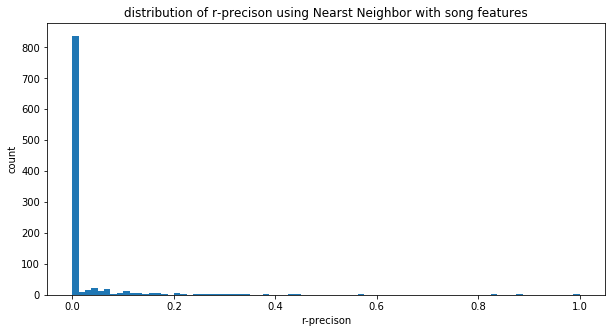

In [22]:
plt.figure(figsize=(10,5))
plt.title('distribution of r-precison using Nearst Neighbor with song features')
plt.xlabel('r-precison')
plt.ylabel('count')
plt.hist(res, bins=80)
plt.show()

In [23]:
res1 = np.take(res, np.nonzero(res)[0])

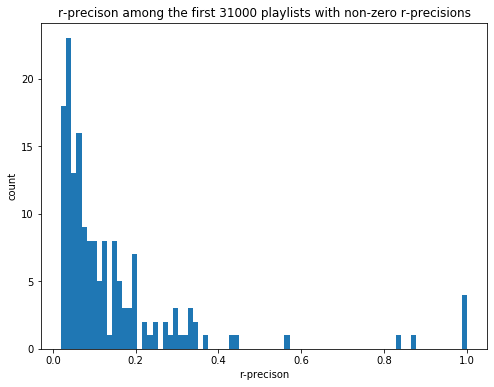

In [24]:
plt.figure(figsize=(8,6))
plt.title('r-precison among the first 31000 playlists with non-zero r-precisions')
plt.xlabel('r-precison')
plt.ylabel('count')
plt.hist(res1, bins=80)
plt.show()

# euclidean distance

In [25]:
res_euc = recommend_eval(dic1, dic, 0.8, euc_sim, False)

In [26]:
np.mean(res_euc)

0.05379618490442853

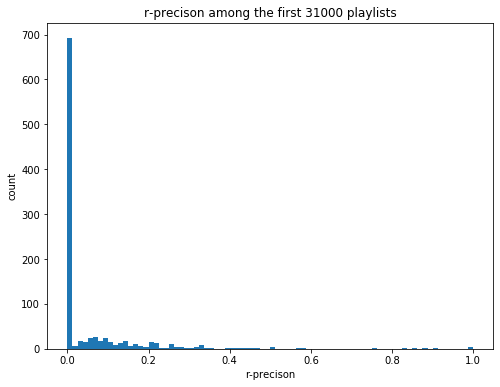

In [27]:
plt.figure(figsize=(8,6))
plt.title('r-precison among the first 31000 playlists')
plt.xlabel('r-precison')
plt.ylabel('count')
plt.hist(res_euc, bins=80)
plt.show()

In [28]:
res2 = np.take(res_euc, np.nonzero(res_euc)[0])

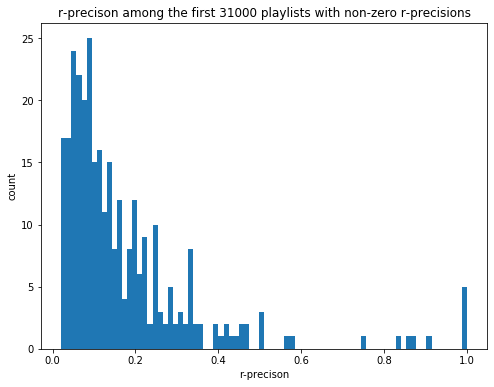

In [29]:
plt.figure(figsize=(8,6))
plt.title('r-precison among the first 31000 playlists with non-zero r-precisions')
plt.xlabel('r-precison')
plt.ylabel('count')
plt.hist(res2, bins=80)
plt.show()

In [30]:
np.mean(res2)

0.17466293800139132